# Using Computer Vision to Predict Ages Based off of a Picture of a Face

## Introduction ##
Good Seed, a supermarket chain, is attempting to use Data Science to adhere to alcohol age limit laws by making sure that they're not selling alcohol to underage individuals. The task in this project is to use a data set with 7,600 images of faces of ages ranging from 1 to 100, to predict the age of each picture. Then Good Seed can use the predictive model to verify people's age using in store cameras.

## Initialization

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [ ]:
# Read the labels csv into dataframe
labels = pd.read_csv('/datasets/faces/labels.csv')

# show the first five rows of data
display(labels.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
# Initialize the training and validation sets
train_datagen = ImageDataGenerator(
    validation_split=.25)

validation_datagen =ImageDataGenerator(
    validation_split=.25)

In [ ]:
# Read the image files from the datasets directory into the training set
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=15,
    class_mode='raw',
    subset='training',
    seed=8420
)

# Read the image files from the datasets directory into the validation set
val_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=15,
    class_mode='raw',
    subset='validation',
    seed=8420
)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


## EDA

In [ ]:
# Call info on the labels dataframe
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# Call describe to get initial statistics
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

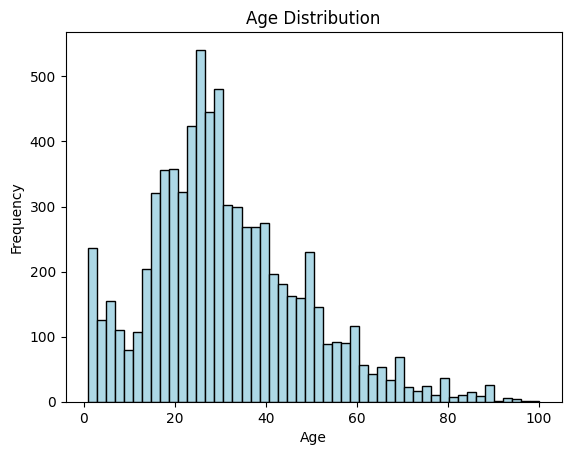

In [ ]:
# Make a histogram to show the age distribution
plt.hist(labels['real_age'], bins=50, color='lightblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Show the counts of ages per decade
# Define the bin edges and labels
bins = list(range(1, 101, 10))
bins.append(101)

labels_decades = [f"{i}-{i + 9}" for i in bins[:-1]]

# Cut ages into bins
labels['age_group'] = pd.cut(labels['real_age'], bins=bins, right=True, labels=labels_decades)

# Count occurrences in each group
age_group_counts = labels['age_group'].value_counts().sort_index()

# Display result
display(age_group_counts)

1-10       610
11-20     1438
21-30     2200
31-40     1383
41-50      901
51-60      492
61-70      236
71-80      104
81-90       66
91-100      12
Name: age_group, dtype: int64

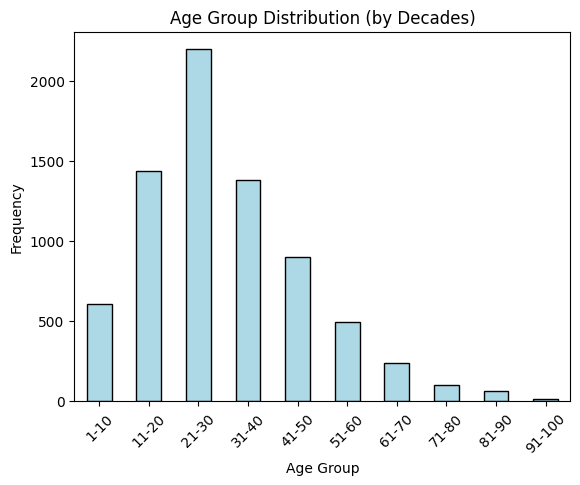

In [ ]:
# Distribution of age by decade
age_group_counts.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Age Group Distribution (by Decades)')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

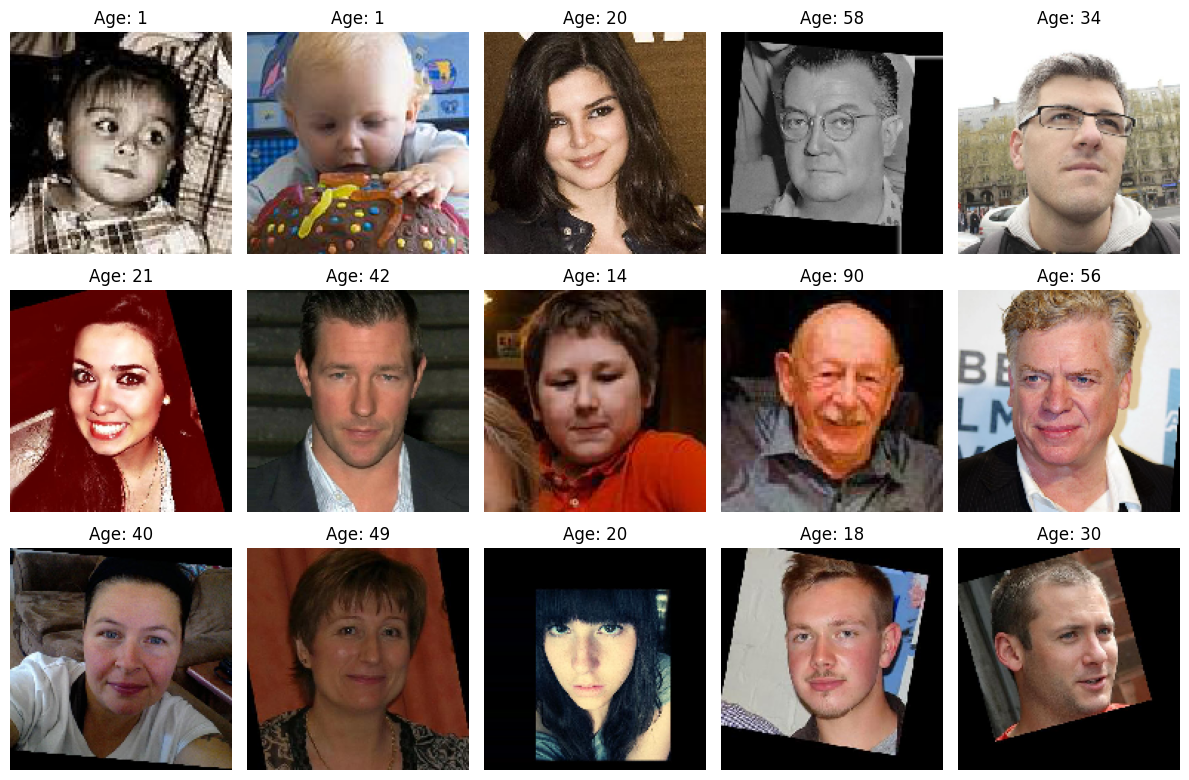

In [ ]:
# Get one batch of images and ages from the generator
images, ages = next(train_gen_flow)

plt.figure(figsize=(12, 8))

# Display the first 15 images in the batch
for i in range(min(15, len(images))):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].astype('uint8'))
    plt.title(f"Age: {int(ages[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Findings

In this photo dataset we have 7591 images, and each image also has a "real_age" attached to it. The age range is from 1 - 100, with an average age of 31 and a standard deviation of 17. When we look at the histogram of the age distribution, we can see that there is a frequency spike in the late 20's and a right skew tail for the older ages. When I divided the data into decade length, we can see that the most values are in the 20's, and there are very few observations in the 60s - 90s. That final decade of observations only accounts for 12 observations in total.

<div class="alert alert-success">
<b>Reviewer's comment V1</b> 

Good job!

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                       directory=path + '/final_files/', 
                                                       x_col='file_name', 
                                                       y_col='real_age', 
                                                       target_size=(150, 150), 
                                                       batch_size=15, 
                                                       class_mode='raw', 
                                                       subset='training', 
                                                       seed=8420)


    return train_gen_flow

In [ ]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    test_gen_flow = validation_datagen.flow_from_dataframe(dataframe=labels,
                                                          directory=path + '/final_files/',
                                                          x_col='file_name',
                                                          y_col='real_age',
                                                          target_size=(150, 150),
                                                          batch_size=15,
                                                          class_mode='raw',
                                                          subset='validation',
                                                          seed=8420)

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(weights='imagenet',
                       input_shape=input_shape,
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(learning_rate=.0005)
    model.compile(optimizer=optimizer, 
                 loss='mse',
                 metrics=['mae'])

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
             validation_data=test_data,
             batch_size=batch_size,
             epochs=epochs,
             steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps,
             verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

The goal of this project was to develop a model that could predict the age of a person based on an image of their face. Over the course of 20 training epochs, the model showed improvement in the training data by decreasing the Mean Absolute Error from 7.43 to 3.18. In the Validation set on the otherhand did not show the same steady decrease over the 20 epochs. Instead, its values ranged from 11.46 to 6.64 with starting MAE of 8.49 and final MAE of 7.65. This means that in the end, this model was able to predict with ages with an error of 7-8 years. 

This dataset was relatively small with only 7,600 observations. And, there was not very much data of individuals ages 60-100. In order to improve the model, gathering more data will help overall predictive quality. 